## Procedures for clipping satelite images

In [24]:
import pyproj
import numpy as np
import json
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt

Loading cordinates from geojson file

In [2]:
# Loading coordinates lat/long
import geojson
file = "geojson/map.geojson"
with open(file) as f:
    gj = geojson.load(f)
cdnts = gj['features'][0]['geometry']['coordinates']
#co = cdnts['coordinates']
cdnts

[[[14.217682, 49.939289],
  [14.712753, 49.939289],
  [14.712753, 50.177778],
  [14.217682, 50.177778],
  [14.217682, 49.939289]]]

In [3]:
[x1, y1] = cdnts[0][0]
print(x1,y1)

14.217682 49.939289


In [4]:
# Transformation to x,y coordinates
transformer = pyproj.Transformer.from_crs("epsg:4326","epsg:32633")
[a, b] = transformer.transform(y1, x1)
print(a, b)

443863.2824773818 5532173.942500703


In [5]:
# Transformation back - the order of coordinates is SWAPED!!!
transformer = pyproj.Transformer.from_crs("epsg:32633", "epsg:4326")
transformer.transform(a,b)

(49.939288999999995, 14.217682)

In [6]:
# Use custom function to put it in correct order
from use_functions import reverse_coordinates
coordinates = [transformer.transform(a,b)]
reverse_coordinates(coordinates)

[[14.217682, 49.939288999999995]]

In [8]:
# Transformation of coordinates
from use_functions import reverse_coordinates

file = "geojson/clip_test_transWindow.geojson"
new_file = "geojson/clip_transWindow_GPS.geojson"

transformer = pyproj.Transformer.from_crs("epsg:32633", "epsg:4326")

k = 0
n = len(cdnts)
m = len(cdnts[0])
trans_coord = [[0]*m for i in range(n)]

with open(file) as f:
    gj = geojson.load(f)

cdnts = gj['features'][0]['geometry']['coordinates']

for i in range(len(cdnts)):
    for j in range(len(cdnts[0])):
        [x1, y1] = cdnts[i][j]
        trans_coord[0][k] = transformer.transform(x1, y1)
        k += 1

k = 0
cord = [[0] for i in range(len(trans_coord[0]))]
for i in range(len(trans_coord)):
    for j in range(len(trans_coord[0])):
        cord[k] = trans_coord[i][j]
        k += 1
rev_cord = reverse_coordinates(cord)

k = 0
n = 1
m = len(rev_cord)
matrix_coord = [[0]*m for i in range(n)]
for cor in rev_cord:
    matrix_coord[0][k] = rev_cord[k]
    k += 1

matrix_coord
            
with open(file, 'r') as f:
    data = json.load(f)

data['features'][0]['geometry']['coordinates'] = matrix_coord
    
with open(new_file, 'w+') as f:
    json.dump(data, f)
    
print("The file {} has been saved!".format(new_file))

The file geojson/clip_transWindow_GPS.geojson has been saved!


### Converting coordinates using custom function coordinates_converter

In [10]:
# Generated from BoundingBox method
with open('geojson/clip_BoundingBox_GPS.geojson', 'r') as f:
    data = json.load(f)

data['features'][0]['geometry']['coordinates']

[[[13.616762732863865, 49.5564878429554],
  [14.607815388601736, 49.56409049902708],
  [14.603552975753772, 50.08844718949461],
  [13.601734638623121, 50.080703020971406],
  [13.616762732863865, 49.5564878429554]]]

In [12]:
# Generated from window_slice
with open('geojson/clip_transWindow_GPS.geojson', 'r') as f:
    data = json.load(f)

data['features'][0]['geometry']['coordinates']

[[[13.601734638623121, 50.080703020971406],
  [14.603552975753772, 50.08844718949461],
  [14.607815388601736, 49.56409049902708],
  [13.616762732863865, 49.5564878429554],
  [13.601734638623121, 50.080703020971406]]]

In [14]:
import geojson
from use_functions import reverse_coordinates, to_index, generate_polygon, pol_to_np, pol_to_bounding_box

# Loading coordinates lat/long
file = "geojson/map.geojson"
with open(file) as f:
    gj = geojson.load(f)

cord = gj['features'][0]['geometry']['coordinates']

k = 0
cord_list = [[0] for i in range(len(cord[0]))]
for i in range(len(cord)):
    for j in range(len(cord[0])):
        cord_list[k] = cord[i][j]
        k += 1

bbox = pol_to_bounding_box(cord_list)
bbox

BoundingBox(left=14.217682, bottom=49.939289, right=14.712753, top=50.177778)

In [15]:
import rasterio
from rasterio import warp
epsg = 32633
bounds_trans = warp.transform_bounds({'init': 'epsg:4326'},"epsg:"+str(epsg),*bbox)
print(bounds_trans)
pol_bounds_trans = generate_polygon(bounds_trans)
pol_bounds_trans

(443863.2824773818, 5531920.156945999, 479489.8746502225, 5558690.077325832)


[[443863.2824773818, 5531920.156945999],
 [479489.8746502225, 5531920.156945999],
 [479489.8746502225, 5558690.077325832],
 [443863.2824773818, 5558690.077325832],
 [443863.2824773818, 5531920.156945999]]

In [16]:
k = 0
n = 1
m = len(pol_bounds_trans)
matrix_coord = [[0]*m for i in range(n)]
for cor in pol_bounds_trans:
    matrix_coord[0][k] = pol_bounds_trans[k]
    k += 1

matrix_coord

[[[443863.2824773818, 5531920.156945999],
  [479489.8746502225, 5531920.156945999],
  [479489.8746502225, 5558690.077325832],
  [443863.2824773818, 5558690.077325832],
  [443863.2824773818, 5531920.156945999]]]

In [17]:
import json

with open(file, 'r') as f:
    data = json.load(f)

data['features'][0]['geometry']['coordinates'] = matrix_coord
    
new_file = "geojson/prague_bbox.geojson"    
with open(new_file, 'w+') as f:
    json.dump(data, f)
    
print("The file {} has been saved!".format(new_file))

The file geojson/prague_bbox.geojson has been saved!


In [19]:
from bbox_converter import bbox_converter
bbox_converter("geojson/map.geojson","geojson/prague_bbox_test.geojson",32633)

The file geojson/prague_bbox_test.geojson has been saved!


In [22]:
%%time
from image_clip import clipper
clipper("S2B_MSIL1C_20210617T100559_N0300_R022_T33UVR_20210617T121634.SAFE/GRANULE/L1C_T33UVR_A022356_20210617T101301/IMG_DATA/","geojson/prague_bbox_test.geojson","Prague_sunny/")

All clipped images are saved in Prague_sunny/ folder!
CPU times: user 42 s, sys: 1.83 s, total: 43.8 s
Wall time: 23.2 s


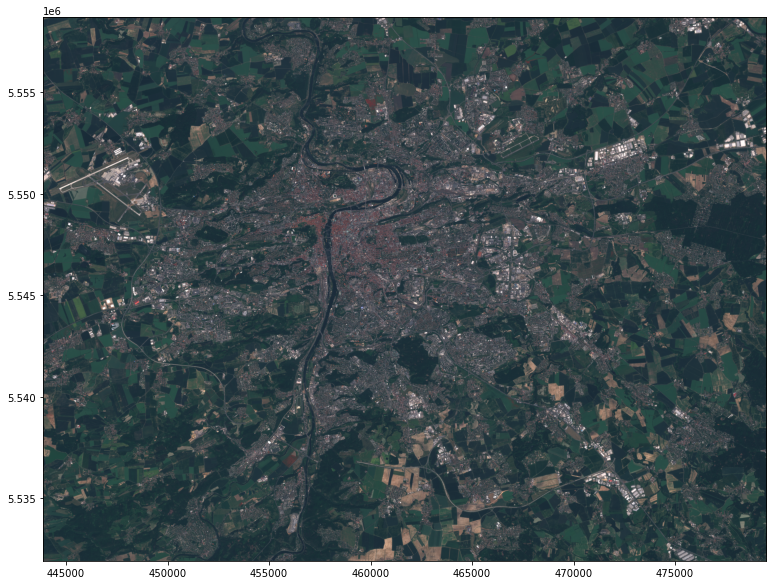

<AxesSubplot:>

In [25]:
plt.figure(figsize=(15,10))
clipped_img = rasterio.open("Prague_sunny/TCI.tif")
show(clipped_img)